<font size = '6'>Remote Sensing with Google Earth Engine<br></font>
<font size = '5'>Ginny Cousens & Albert Larson<br></font>
<font size = '4'>University of Rhode Island<br></font>
<font size = '3'>OCG404 / CSC593<br></font>
<font size = '2'>Prof. Brice Loose / Fall 2020 Final Project</font>

In [44]:
import ee, os, geemap, pandas as pd, rasterio, numpy as np, matplotlib.pyplot as plt, glob, cartopy.crs as ccrs
from geemap import cartoee
from rasterio.plot import show
from IPython.display import YouTubeVideo

#In some instances, Google Earth Engine will require the Authenticate function. With geemap, 
#sometimes this is not necessary. If the package does not initialize, run Authenticate. It will
#open a new window, ask you to login with your Google account associated with Google Earth Engine.
#Then it will provide you with a code to enter enter for authentication.

# ee.Authenticate()
ee.Initialize()

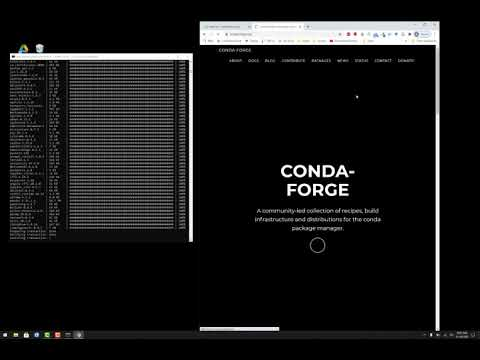

In [72]:
YouTubeVideo('okgIS7CjFmA')

<font size = '5'> Acquiring Landsat images<br>
<font size = '4'> The below creates and opens a "map" object built on the ipyleaflet and bakedinto geemap. It also creates four different layers. Two layers are based on NASA's Shuttle Radar Topography Mission (SRTM) and the other two layers are Landsat images. The SRTM dataset provides elevation at any given point, and slope at a given point is a derived variable.<br><br>Landsat is the longest-running enterprise for satellite imagery acquisition on Earth. The first satellite was launched on July 23, 1972. It's a joint program between the National Aeronautics and Space Administration and the United States Geological Survey.<br><br>Both Landsat images downloaded are from the same geographic area. Landsat 8 has a 16-day repeat cycle. The code looks between January 1st and March 1st of two different years, sorts the images by percent cloud cover, selects the first image (least cloud cover), and assigns bands 1-7 to a variable.<br><br>We create another variable known as the visulization parameters. These are just for presenting the image here as a nice reference. While there is a functionality to be able to export the visualized Landsat image, it's not really useful from a computational point of view.

In [47]:
# point = ee.Geometry.MultiPoint([-119,38.5,-118.5,39])
point = ee.Geometry.MultiPoint([86.7,27.5,87,27.8])


#https://developers.google.com/earth-engine/datasets/catalog/CGIAR_SRTM90_V4
image1 = ee.Image("CGIAR/SRTM90_V4")
elevation = image1.select('elevation')
slope = ee.Terrain.slope(elevation)


#https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR
image2 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(point) \
    .filterDate('2015-01-01','2015-03-01') \
    .sort('CLOUD_COVER') \
    .first() \
    .select('B[1-7]')

image3 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(point) \
    .filterDate('2019-01-01','2019-03-01') \
    .sort('CLOUD_COVER') \
    .first() \
    .select('B[1-7]')

vis_params = {
    'min': 0,
    'max': 5000,
    'bands': ['B6', 'B5', 'B2']
}

# Map = geemap.Map(center=[38.8,241.3],zoom=8)
Map = geemap.Map(center=[27.4881, 86.9250],zoom=8)

Map.addLayer(elevation,{min:0, max:60},'elevation')
Map.addLayer(slope,{min:0, max:60},'slope')
Map.addLayer(image2,vis_params,'L2015')
Map.addLayer(image3,vis_params,'L2019')

Map

Map(center=[27.4881, 86.925], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton…

Below is a bit of code to grab the elevation given a set of coordinates. You can also perform this algorithmically, but this is a nice method if you're looking to perform the operation logarithmatically.

In [21]:
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = image1.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)


# Links to the Landsat images

# https://drive.google.com/file/d/1L-qA2uUBhO6lyJYKSUUS8Qg2DDyoJEdh/view?usp=sharing,%20
#     https://drive.google.com/file/d/1OXUu_tPab5kHOXL2FoCofodcQoFI__Nx/view?usp=sharing,%20
#         https://drive.google.com/file/d/1pJ-rUlEZwQkFo2CXWVdPk_Gu4wGQFYQr/view?usp=sharing

Mount Everest elevation (m): 8794


In [75]:
# geemap.ee_export_image_to_drive(image2,'landsat_2015_everest_532', scale=532)

Exporting landsat_2015_everest_532 ...


<font size = '5'> Extracting data from Landsat images<br>
<font size = '4'>Below is a simple way to grab a few pieces of metadata from the Landsat imagery. This is definitely not exhaustive. When comparing change of an area over time, it's wise to see if you're looking at the same time frame. As you can see, the images are not just four years apart, but they're also roughly a month apart. Not a big deal here, but if you were looking at the loss of snow pack, for example, in the Himalayas, and you were targeting the Springtime you could make a crucial error by allowing yourself to use anniversary images that don't occur around a small deviation of monthly time.

In [39]:
date = ee.Date(image2.get('system:time_start'))
print(date.format('M-d-Y').getInfo())
date = ee.Date(image3.get('system:time_start'))
print(date.format('M-d-Y').getInfo())


2-2-2015
1-12-2019


../final_project_593/landsat_2015_everest_23.tif


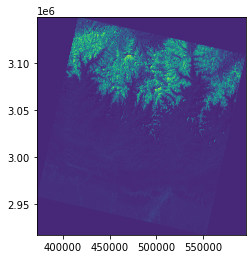

Average NDVI is 0.407
Width of image in pixels is 9702
Height of image in pixels is 10096


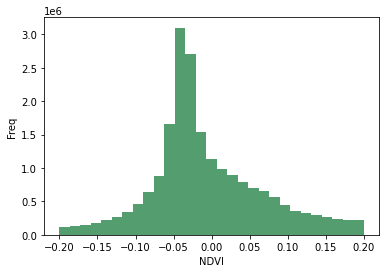



../final_project_593/landsat_2015_everest_50.tif


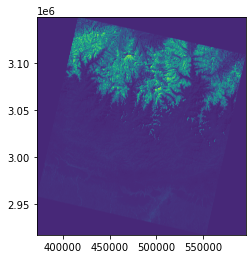

Average NDVI is 0.407
Width of image in pixels is 4463
Height of image in pixels is 4644


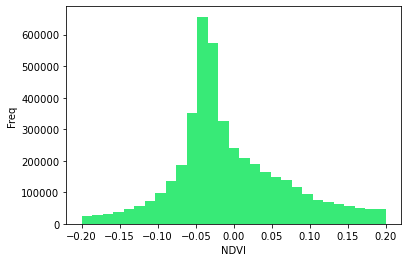



../final_project_593/landsat_2015_everest_532.tif


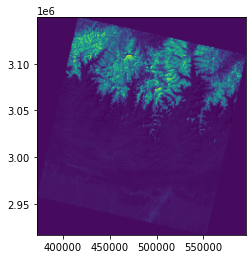

Average NDVI is 0.399
Width of image in pixels is 420
Height of image in pixels is 437


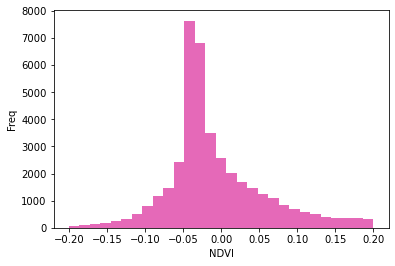

In [86]:
#Computing NDVI has runtime warnings. This suppresses the warnings because it's annoying to look at.
import warnings, random
warnings.filterwarnings("ignore")

#This makes it easier to iterate over a few different resolution images I downloaded for the Landsat demo.
filepath = "../final_project_593/*.tif"
landsats = glob.glob(filepath)
for i in landsats:
    src = rasterio.open(i)
    print(i)
    show(src)
    
    #computes NDVI
    red = np.array(src.read(4))
    nir = np.array(src.read(5))
    ndvi = (nir-red)/(nir+red)
    ndvi = np.where(ndvi==np.inf,np.nan,ndvi)
    ndvi = np.where(ndvi==np.NINF,np.nan,ndvi)
    av_ndvi = np.nanmean(ndvi)
    print("Average NDVI is", round(av_ndvi,3))
    
    #Only grabs values that are not nans using tilde (~)
    ndvi = ndvi[~np.isnan(ndvi)]
    print("Width of image in pixels is", src.width)
    print("Height of image in pixels is", src.height)
    x = np.linspace(-.2,.2,30)
    
    #Plots histogram of NDVI
    rgb = (random.random(), random.random(), random.random())
    plt.hist(ndvi,bins=x,color=rgb)
    plt.xlabel('NDVI')
    plt.ylabel('Freq')
    plt.show()
    print()
    print()

<font size = '5'>Plotting locations in the interactive map<br>
<font size = '4'>The geemap package allows the user to easily add points to the interactive map from a csv file. The points are added as a layer and can be toggled on and off just like basemaps or earth engine data layers added to the map.

Here we added a data layer that contains satelite imagery from MODIS. Because this is earth engine data, you can use the inspector and plotting tools to analyze the layer. 

In [48]:
Map = geemap.Map(center=[-70, -120], zoom = 2)
Map

Map(center=[-70, -120], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value…

In [49]:
in_csv = 'https://raw.githubusercontent.com/OCG-CSC-GEE/final_project/main/Example_Locations_2.csv'
points = geemap.xy_to_points(in_csv, latitude='Lat', longitude='Lon')
Map.addLayer(points, {}, 'Data 2')

Data downloaded to: /Users/ael/Downloads/Example_Locations_2.csv


In [50]:
in_csv = 'https://raw.githubusercontent.com/OCG-CSC-GEE/final_project/main/Example_Locations_1.csv'
points2 = geemap.xy_to_points(in_csv, latitude='lat', longitude='lon')
Map.addLayer(points2, {}, 'Data 1')

Data downloaded to: /Users/ael/Downloads/Example_Locations_1.csv


<font size = '5'>Cartopy and google earth engine<br>
<font size = '4'>The geemap python package includes a module that allows the user to used earth engine data with cartopy without having to download imagery. Here we use the same satelite imagery as above and create a cartopy map in just a few lines of code. 

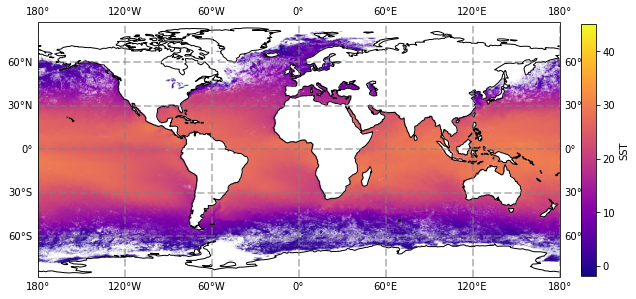

In [20]:
ocean = (
    ee.ImageCollection('NASA/OCEANDATA/MODIS-Terra/L3SMI')
    .filter(ee.Filter.date('2018-01-01', '2018-03-01'))
    .median()
    .select(["sst"],["SST"])
)

visualization = {'bands':"SST",'min':-2,'max':45}

bbox = [-180,-88,180,88]

fig = plt.figure(figsize=(10,7))

ax = cartoee.get_map(ocean,cmap='plasma',vis_params=visualization,region=bbox)
cb = cartoee.add_colorbar(ax,vis_params=visualization,loc='right',cmap='plasma')

ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
plt.show()

<font size = '5'>Creating a timelapse</font><br>
<font size = '4'>Google earth engine hosts large time series of data. It is useful to be able to visual the changes over time. The geemap package for jupyter notebook allows us to do this very easily. The same thing can be done in java script like the other examples in this notebook.

This example uses a sea surface temperature model. It displays continuous images of sea surface temperature for the month of January.<br><br>

Geemap functions allow us to download and save the gif. 

In [53]:
data = ee.ImageCollection("NASA/OCEANDATA/MODIS-Terra/L3SMI").filter(ee.Filter.date('2018-01-01', '2018-03-01'))
sst = data.select('sst')
vis_params = {
   'min': -2,
   'max': 30,
   'palette': ['blue', 'cyan', 'green', 'yellow']
}

Map.addLayer(sst,vis_params,'sst')

In [26]:
aois = []

aoi1 = ee.Geometry.Polygon(
    [[[-82.81, -57.50], [-82.81, 14.60], [-30.22, 14.60], [-30.22, -57.50]]], None, False)

aoi2 = ee.Geometry.Polygon(
   [[[-90, 75], [-90.0, 15], [10, 15], [10, 75]]], None, False)

aois.append(aoi1)
aois.append(aoi2)

for i in aois:
    tempCol = ee.ImageCollection('NOAA/GFS0P25').filterDate('2010-01-01', '2020-01-31').limit(24).select('temperature_2m_above_ground')
    videoArgs = {
        'dimensions': 600,
        'region': i,
        'framesPerSecond': 5,
        'crs': 'EPSG: 3857',
        'min': -40.0,
        'max': 35.0,
        'palette': ['blue', 'purple', 'cyan', 'green', 'yellow', 'red']
    }
    saved_gif = os.path.join(os.path.expanduser('~'), 'Downloads/temperature_%s.gif' %(aois.index(i)))
    geemap.download_ee_video(tempCol, videoArgs, saved_gif)
    geemap.show_image(saved_gif)

Generating URL...
Please wait ...
The GIF image has been saved to: /Users/ael/Downloads/temperature_0.gif


Output()

Generating URL...
Please wait ...
The GIF image has been saved to: /Users/ael/Downloads/temperature_1.gif


Output()